In [353]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform
from scipy.linalg import eigh
from scipy.linalg import cholesky, cho_solve

In [354]:
class RBFKernel:
  def __init__(self, variance = 1.0, length_scale = 1.0):
    self.variance = variance
    self.length_scale = length_scale

  def __call__(self, X1, X2):
    K = (self.variance)*(np.exp(-cdist(X1, X2, 'sqeuclidean')/(2*self.length_scale**2)))
    return K

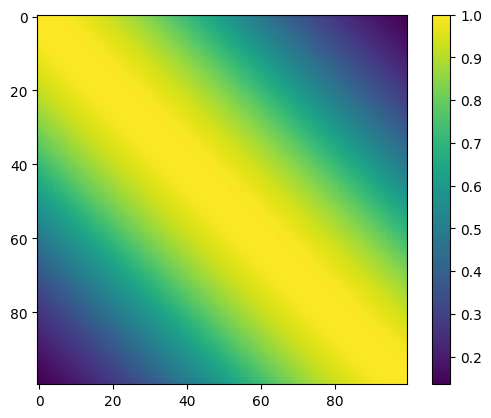

In [355]:
X = np.linspace(0, 1, 100).reshape(-1, 1)
rbf = RBFKernel(variance=1.0, length_scale=0.5)
K = rbf(X, X)
plt.imshow(K)
plt.colorbar()

To do :
- To implement marginal loss likelihood function to compute the loss for the given model.

In [356]:
class GaussianProcessRegressor:
  def __init__(self, kernel, noise_variance = 1e-8) -> None:
    self.kernel = kernel
    self.noise_variance = noise_variance
    self.X_train = None
    self.y_train = None

  def fit(self, X, y) -> None:
    self.X_train = X
    self.y_train = y
    self.K11 = self.kernel(X,X) + self.noise_variance*np.eye(X.shape[0])
    self.L = cholesky(self.K11, lower=True)
    self.alpha = cho_solve((self.L, True), y)

  def predict(self, X) :
    K21 = self.kernel(X, self.X_train)
    mean = K21 @ self.alpha
    K22 = self.kernel(X, X)
    var = K22 - (K21 @ cho_solve((self.L, True), K21.T))
    diag_indices = np.diag_indices_from(var)
    var[diag_indices] = np.clip(var[diag_indices], 1e-8,np.inf)
    return mean, var
  def loss(self):
    negative_log_marginal_likelihood = self.y_train.T @ self.alpha
    penalty_term = 2*np.sum(np.log(np.diag(self.L)))
    constant_term = self.X_train.shape[0]*np.log(2*np.pi)
    return 0.5*(negative_log_marginal_likelihood+penalty_term+constant_term)


In [357]:
np.random.seed(42)
X_train = np.linspace(0, 5, 6).reshape(-1, 1)
y_train = np.sin(X_train).ravel() + 0.1 * np.random.randn(6)
X_test = np.linspace(0, 5, 50).reshape(-1, 1)

In [358]:
my_model = GaussianProcessRegressor(kernel=RBFKernel(length_scale=1,variance=1),noise_variance=1e-6)
my_model.fit(X_train, y_train)
my_mean, my_cov = my_model.predict(X_test)

In [359]:
from sklearn.gaussian_process import GaussianProcessRegressor as SkGPRegressor
from sklearn.gaussian_process.kernels import RBF

sk_model = SkGPRegressor(kernel=1*RBF(length_scale=1), alpha=1e-6,optimizer=None)
sk_model.fit(X_train, y_train)
sk_mean, sk_std = sk_model.predict(X_test, return_std=True)

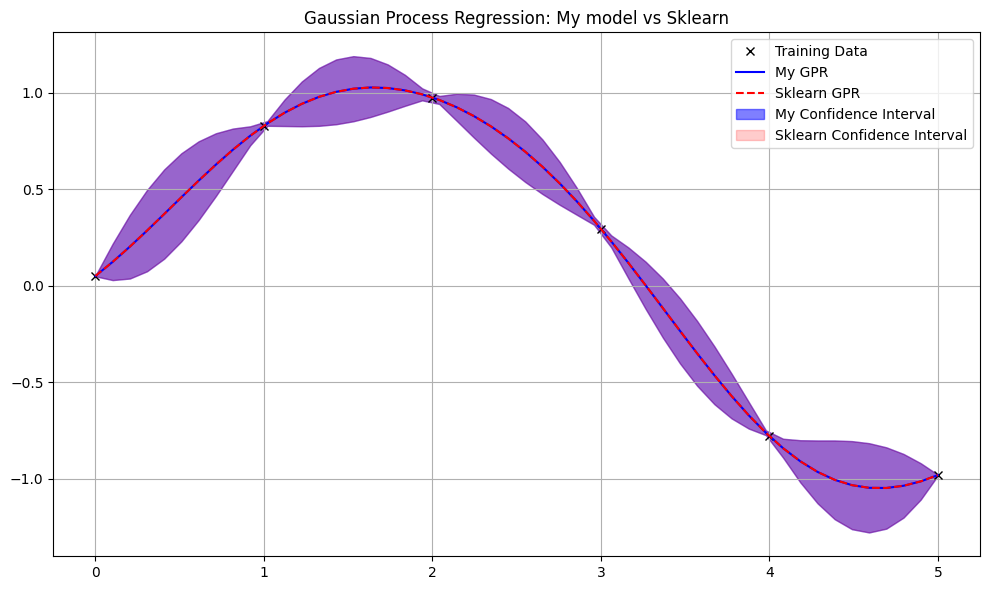

In [360]:
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'kx', label="Training Data")
plt.plot(X_test, my_mean, 'b-', label="My GPR")
plt.plot(X_test, sk_mean, 'r--', label="Sklearn GPR")

plt.fill_between(X_test.ravel(),
                 my_mean - 1.96 * np.sqrt(np.diag(my_cov)),
                 my_mean + 1.96 * np.sqrt(np.diag(my_cov)),
                 alpha=0.5, color='blue', label="My Confidence Interval")

plt.fill_between(X_test.ravel(),
                 sk_mean - 1.96 * sk_std,
                 sk_mean + 1.96 * sk_std,
                 alpha=0.2, color='red', label="Sklearn Confidence Interval")

plt.title("Gaussian Process Regression: My model vs Sklearn")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [361]:
neg_loss_sk = -sk_model.log_marginal_likelihood_value_
print("Sklearn Negative Log-Marginal Likelihood Loss:", neg_loss_sk)

neg_loss_my = my_model.loss()
print("My model Negative Log-Marginal Likelihood Loss:", neg_loss_my)


Sklearn Negative Log-Marginal Likelihood Loss: 5.171980734966393
My model Negative Log-Marginal Likelihood Loss: 5.171980734966393


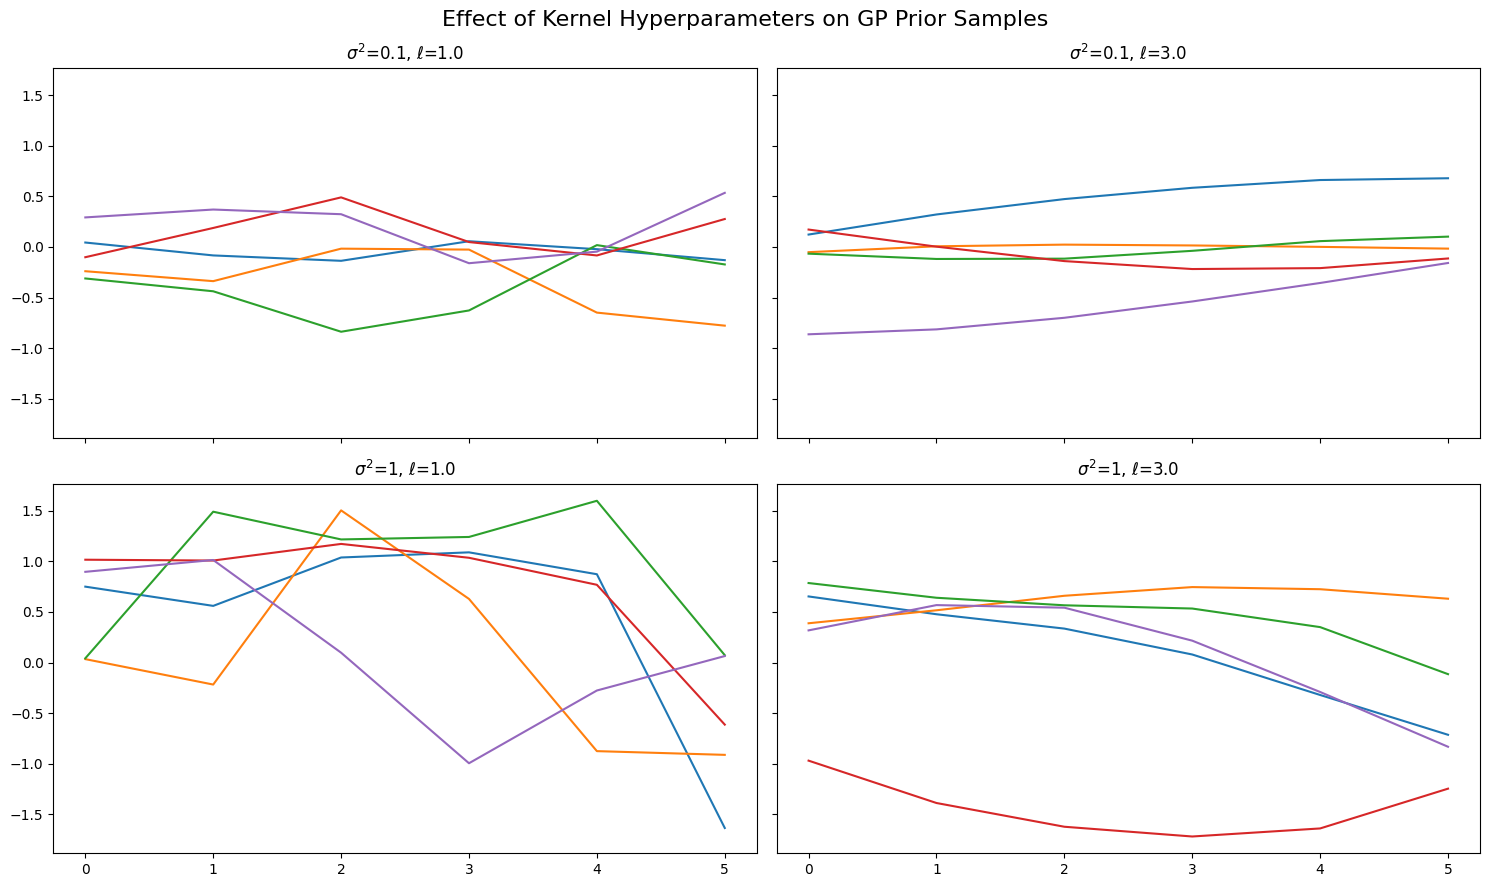

In [365]:
sigmas = [0.1, 1]
lengthscales = [1.0, 3.0]

fig, axes = plt.subplots(len(sigmas), len(lengthscales), figsize=(15, 9), sharex=True, sharey=True)

for i, sigma in enumerate(sigmas):
  for j, l in enumerate(lengthscales):
    rbf = RBFKernel(variance=sigma, length_scale=l)
    K = rbf(X_train,X_train)
    K += 1e-6 * np.eye(len(X_train))

    samples = np.random.multivariate_normal(np.zeros(len(X_train)), K, size=5)

    ax = axes[i, j]
    for s in samples:
      ax.plot(X_train, s)
    ax.set_title(f"$\sigma^2$={sigma}, $\\ell$={l}")
    # ax.set_xticks([])
    # ax.set_yticks([])

fig.suptitle("Effect of Kernel Hyperparameters on GP Prior Samples", fontsize=16)
plt.tight_layout()
plt.show()